# Durée passée dans chaque lieu selon la plage horaire

## I - Base de données

In [23]:
''' Importation des packages nécessaires '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt
import scipy.stats
!pip install openpyxl

In [24]:
emp_df=pd.read_excel("data/data.xlsx")
nb_dep_df=emp_df.groupby("IDENT_IND")["num_dep_V"].max().to_frame().rename(columns={"num_dep_V":"nb_dep"})
emp_df=emp_df.set_index("IDENT_IND")
emp_df["nb_dep"]=nb_dep_df["nb_dep"]
emp_df=emp_df.reset_index()
emp_df.head()

,IDENT_IND,Unnamed: 0,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep
0,110000011400001,0,9891.108772,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Domicile,Parking,mercredi,14.25,14.333333,2029-01-03 14:15:00,2029-01-03 14:20:00,2.20000,Particulier,Particulier,1,2
1,110000011400001,1,9891.108772,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,mercredi,14.75,14.833333,2029-01-03 14:45:00,2029-01-03 14:50:00,2.20000,Particulier,Particulier,2,2
2,110000011500001,2,5275.295948,"Étudier (école, lycée, université)",Emplacement dans un parking public ou commerci...,Domicile,Parking,vendredi,7.75,8.750000,2029-01-05 07:45:00,2029-01-05 08:45:00,28.00000,Particulier,Particulier,1,2
3,110000011500001,3,5275.295948,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,vendredi,10.50,11.000000,2029-01-05 10:30:00,2029-01-05 11:00:00,28.00000,Particulier,Particulier,2,2
4,110000013500002,4,24058.724023,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Domicile,Entreprise,mercredi,15.00,15.250000,2029-01-03 15:00:00,2029-01-03 15:15:00,5.32141,Particulier,Particulier,1,2


In [25]:
data=emp_df
data["Durée"]=0 #On crée une colonne "durée"
data.loc[data["nb_dep"]==1,"Durée"]=24-data["HEURE_ARRIVEE"]
data.loc[data["nb_dep"]==data["num_dep_V"],"Durée"]=24-data["HEURE_ARRIVEE"]
#On remplit la colonne "durée" en faisant la différence entre l'heure du prochain départ de l'individu et l'heure d'arriver à son lieu actuel.
data.loc[(data["nb_dep"]!=1)&(data["nb_dep"]!=data["num_dep_V"]),'Durée'] = data.groupby('IDENT_IND')["HEURE_DEPART"].shift(-1) - data["HEURE_ARRIVEE"]

/tmp/ipykernel_1568/2682466481.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.91666667  4.91666667 13.75       14.66666667 11.5         8.66666667
  0.          6.5         1.5         7.33333333  5.         15.
 10.25       11.         15.          6.5        12.75       15.
 16.66666667  7.         12.25        0.          6.83333333  0.
  6.83333333 10.75       14.93333333  8.75        4.5        13.66666667
 17.33333333  5.16666667 15.25       14.5        12.33333333 13.83333333
  2.5         5.          7.83333333  4.83333333 13.          7.5
 16.91666667 17.08333333  5.          9.25        0.25       10.75
 12.25       11.         15.75        7.5         3.5        10.75
  1.5        15.          7.58333333  4.5         7.75        2.5
  5.5        12.83333333  3.         17.         10.         15.5
  5.          5.25       16.08333333 15.75        8.         14.25
  5.5         8.     

### Séparation de la base de données en 4 plages horaires (pour les heures de départ)

In [26]:
emp_df=data
# Matin (départ entre 00h et 11h) :
emp_matin=emp_df[emp_df["HEURE_DEPART"]<=11]
# Midi (départ entre 11h et 14h) :
emp_midi=emp_df[(emp_df["HEURE_DEPART"]>11)&( emp_df["HEURE_DEPART"]<=14)]
# Après-midi (départ entre 14h et 17h) :
emp_am=emp_df[(emp_df["HEURE_DEPART"]>14)&( emp_df["HEURE_DEPART"]<=17)]
# Soir (départ entre 17h et 00h) :
emp_soir=emp_df[(emp_df["HEURE_DEPART"]>17)&( emp_df["HEURE_DEPART"]<=24)]

#### Remarque : Il y a entre 4000 et 7500 déplacements pour chaque plage horaire.

### Représentation graphique de la durée passée dans chaque lieu pour chaque période de la journée :
    

In [87]:
dist_names = ['norm','gamma', 'pareto', 't', 'lognorm', 'invgamma', 'invgauss', 'chi2','beta']

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718:

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le matin')

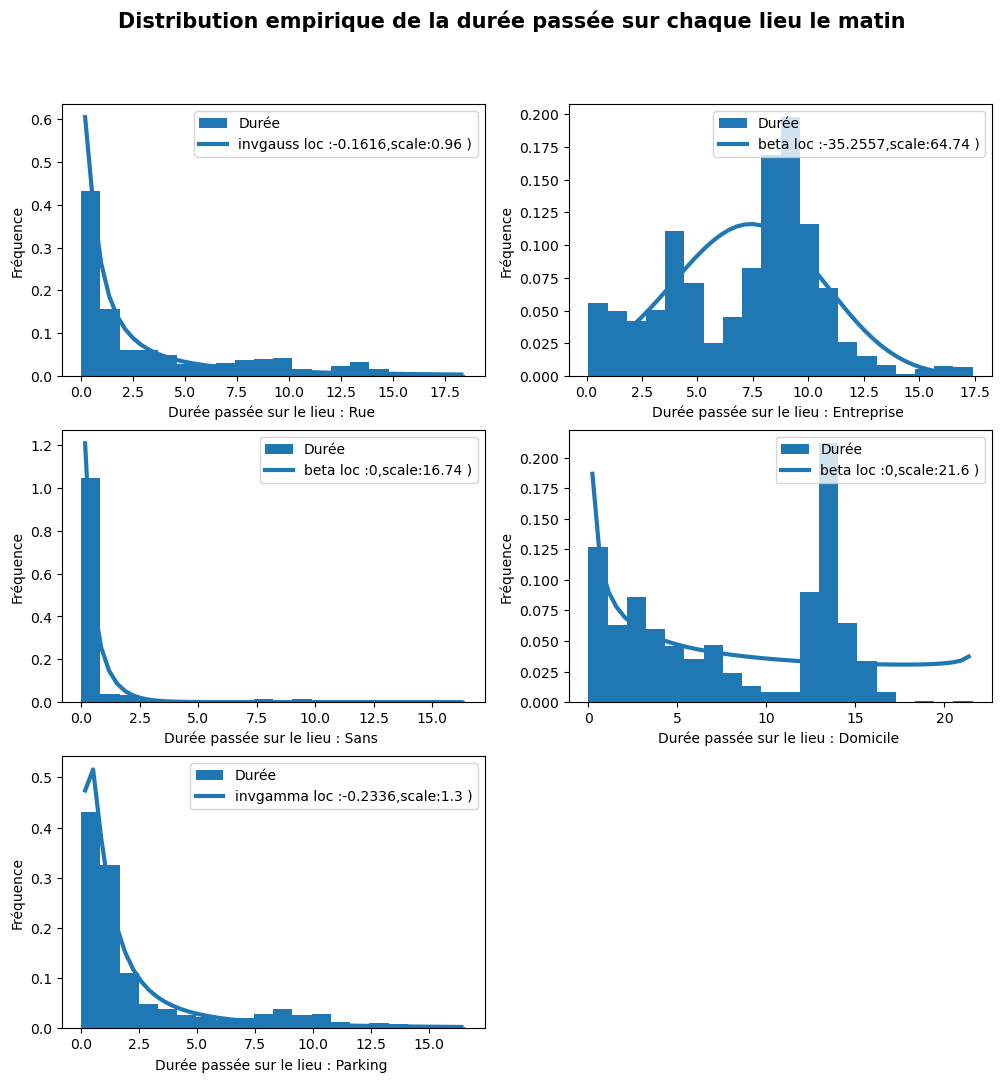

In [102]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_matin=[]

i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

        # Modéliser
        dist = getattr(scipy.stats, name)
        param = dist.fit(data)
        
        # Paramètres
        loc = param[-2]
        if abs(loc)<10**(-2):
            loc=0
        scale = param[-1]
        arg = param[:-2]

        # PDF
        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        # SSE
        model_sse = np.sum((y - pdf)**2)

        # Si le SSE est diminué, enregistrer la loi
        if model_sse < sse:
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_param=param
            best_name = name
    lois_duree_matin.append([best_name,best_param])
        
    ax[i][j].plot(x,best_pdf,label=best_name+" loc :"+str(round(best_loc,4))+",scale:"+str(round(best_scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le matin",va='center', fontweight="bold",fontsize=15,y=0.95)

In [89]:
lois_duree_matin

[['invgauss', (4.036204719120207, -0.16161763541930152, 0.9612597581681632)],
 ['beta',
  (52.595462995358545,
   27.703319219454222,
   -35.25571817939934,
   64.73662886568977)],
 ['beta',
  (0.5117940197816365,
   19.2230902247954,
   -5.458435128107077e-24,
   16.73836142353016)],
 ['beta',
  (0.5474258078179828,
   0.9000121427405545,
   -3.7860672030373568e-28,
   21.599798314360253)],
 ['invgamma', (1.2485500680449202, -0.23360330017153055, 1.298576682245404)]]

In [90]:
emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"]

2         1.750000
13        5.416667
46        0.500000
60        1.000000
86        7.666667
           ...    
21175     1.500000
21179     8.083333
21183    10.750000
21191    14.833333
21199     0.916667
Name: Durée, Length: 1970, dtype: float64

In [91]:
emp_df[emp_df["Durée"].isnull()]

,IDENT_IND,Unnamed: 0,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée


In [65]:
emp_df[emp_df["IDENT_IND"]==930000611500001]

,IDENT_IND,Unnamed: 0,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée


/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718:

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le midi')

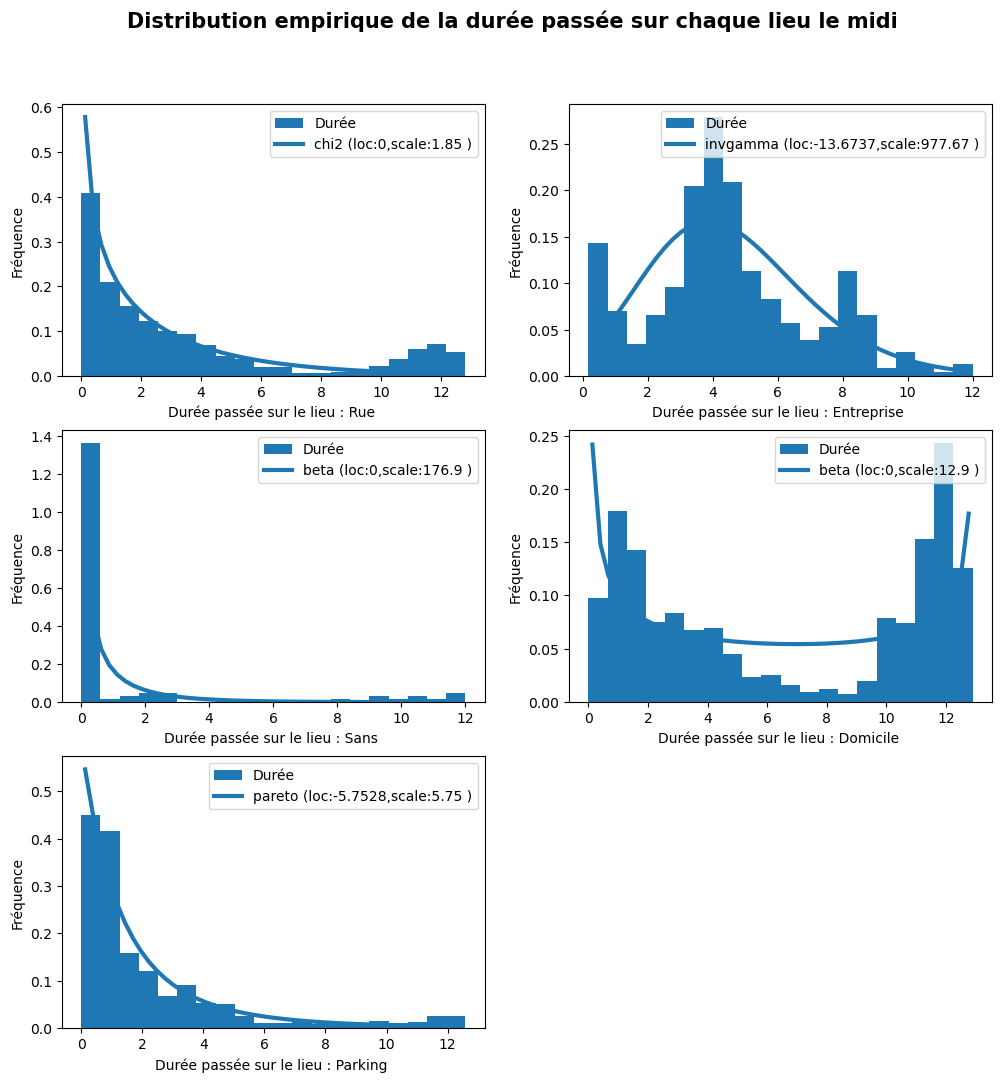

In [92]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_midi=[]
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

        # Modéliser
        dist = getattr(scipy.stats, name)
        param = dist.fit(data)

        # Paramètres
        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]
        if abs(loc)<10**(-2):
            loc=0
        # PDF
        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        # SSE
        model_sse = np.sum((y - pdf)**2)

        # Si le SSE est diminué, enregistrer la loi
        if model_sse < sse:
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_param=param
            best_name = name
    lois_duree_midi.append([best_name,best_param])    
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(best_loc,4))+",scale:"+str(round(best_scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0
ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le midi",va='center', fontweight="bold",fontsize=15,y=0.95)

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480

Text(0.5, 0.95, "Distribution empirique de la durée passée sur chaque lieu l'après-midi")

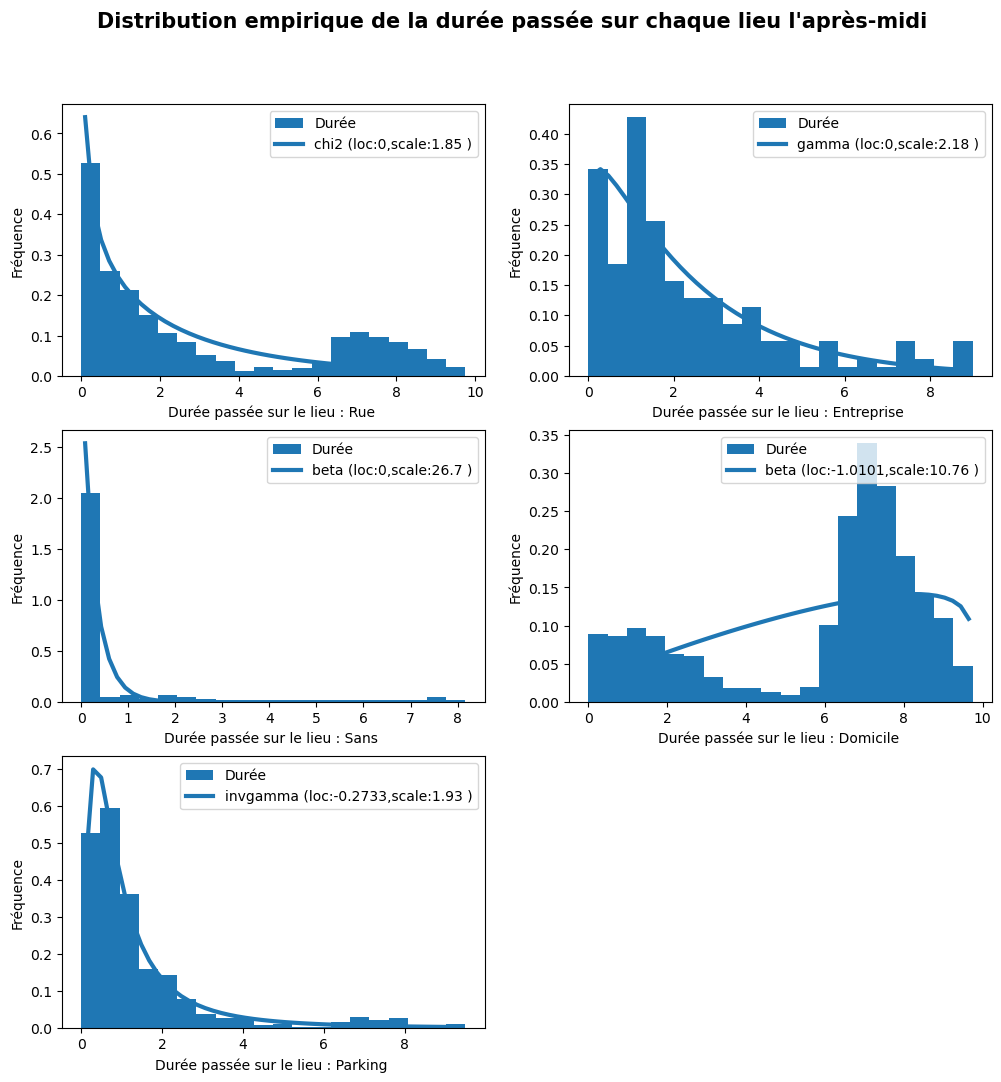

In [93]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_am=[]
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

        # Modéliser
        dist = getattr(scipy.stats, name)
        param = dist.fit(data)

        # Paramètres
        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]
        if abs(loc)<10**(-2):
            loc=0

        # PDF
        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        # SSE
        model_sse = np.sum((y - pdf)**2)

        # Si le SSE est diminué, enregistrer la loi
        if model_sse < sse:
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_param=param
            best_name = name
    
    lois_duree_am.append([best_name,best_param])       
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(best_loc,4))+",scale:"+str(round(best_scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu l'après-midi",va='center', fontweight="bold",fontsize=15,y=0.95)

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723:

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le soir')

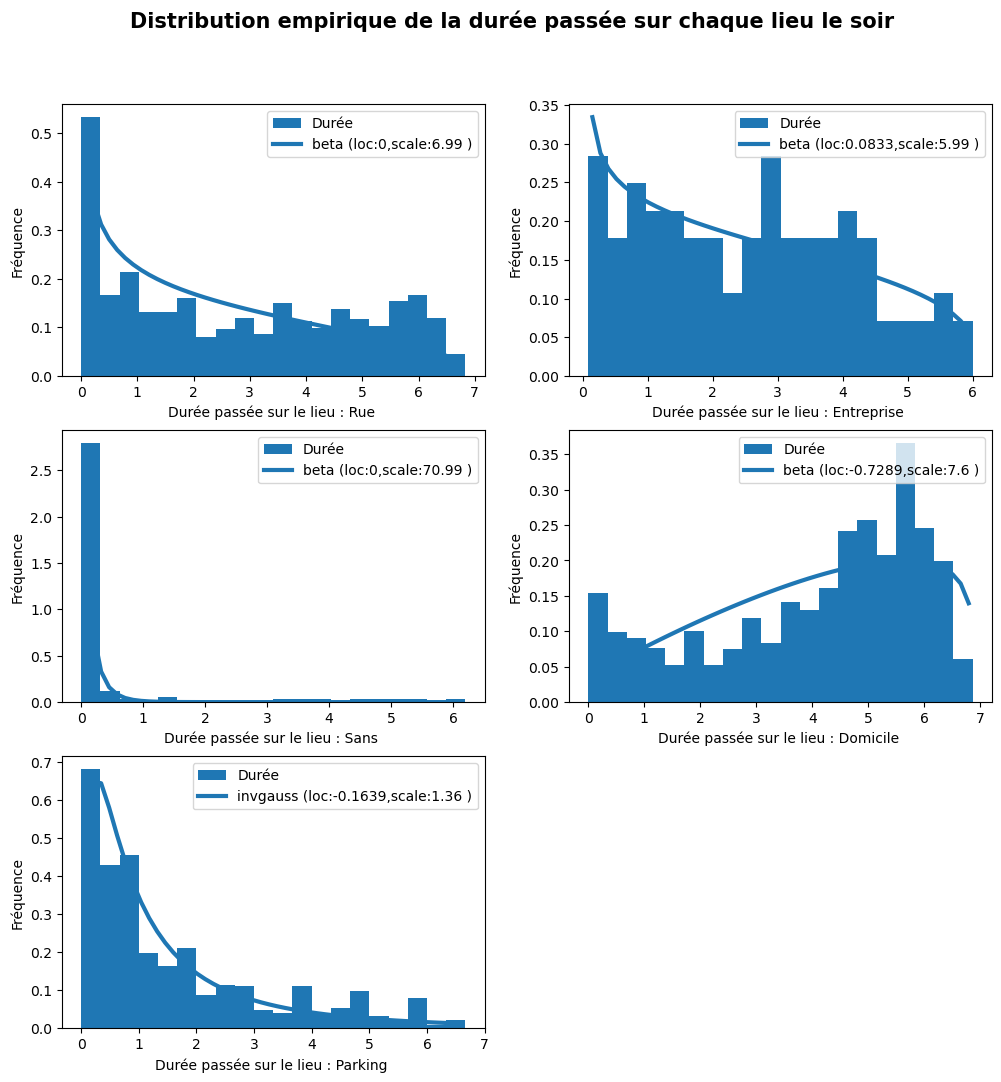

In [94]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
lois_duree_soir=[]
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

        # Modéliser
        dist = getattr(scipy.stats, name)
        param = dist.fit(data)

        # Paramètres
        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]
        if abs(loc)<10**(-2):
            loc=0

        # PDF
        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        # SSE
        model_sse = np.sum((y - pdf)**2)

        # Si le SSE est diminué, enregistrer la loi
        if model_sse < sse :
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_param=param
            best_name = name
    lois_duree_soir.append([best_name,best_param])       
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(best_loc,4))+",scale:"+str(round(best_scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le soir",va='center', fontweight="bold",fontsize=15,y=0.95)

### Tableau des lois suivis pour la durée passée dans chaque lieu :

In [95]:
lois_duree_df=pd.DataFrame(index=["Matin","Midi","Après-midi","Soir"],columns=list(set(emp_df["Lieu_Arrivee"])))

In [96]:
lois_duree_df.loc["Matin"]=lois_duree_matin
lois_duree_df.loc["Midi"]=lois_duree_midi
lois_duree_df.loc["Après-midi"]=lois_duree_am
lois_duree_df.loc["Soir"]=lois_duree_soir

In [97]:
lois_duree_df

,Rue,Entreprise,Sans,Domicile,Parking
Matin,"[invgauss, (4.036204719120207, -0.161617635419...","[beta, (52.595462995358545, 27.703319219454222...","[beta, (0.5117940197816365, 19.2230902247954, ...","[beta, (0.5474258078179828, 0.9000121427405545...","[invgamma, (1.2485500680449202, -0.23360330017..."
Midi,"[chi2, (1.3400808769713695, -5.127648667537803...","[invgamma, (54.707261432752674, -13.6736528297...","[beta, (0.30450496225678947, 88.52544141212059...","[beta, (0.547862902931137, 0.6163748511340661,...","[pareto, (3.474502202630147, -5.75279416070615..."
Après-midi,"[chi2, (1.3380657374339826, -2.022860775150514...","[gamma, (1.1060959455943804, -0.00407001505164...","[beta, (0.8611652542892512, 79.35796489004701,...","[beta, (1.8969335796940112, 1.1440186443623233...","[invgamma, (2.030103317853264, -0.273339157562..."
Soir,"[beta, (0.7222192851774487, 1.4655167671346607...","[beta, (0.8699981002941614, 1.3044457209426563...","[beta, (0.3021326639337568, 266.1616492102139,...","[beta, (1.9493353130904008, 1.1828119830488304...","[invgauss, (1.3223013343950307, -0.16386888664..."


In [98]:
lois_duree_df.to_excel("data/lois_duree.xlsx")

In [43]:
h=(4,5,6)

In [45]:
h[-2]

5